# Hub'Eau time series univariate forecasting

Setup our working environment first in order to be able to display some data and make training/prediction:

In [4]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
tf.random.set_seed(13)

Then read data from a station and display it:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002EFB9C6B688>],
      dtype=object)

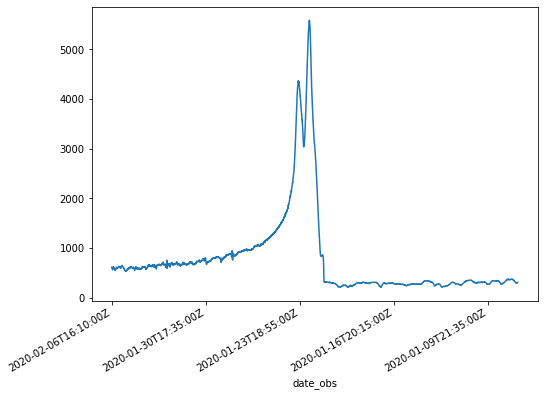

In [10]:
raw = pd.read_csv("data/hubeau_site_Y1422030_30d_10m_L'Aude.csv", delimiter=';')
data = raw['resultat_obs']
data.index = raw['date_obs']
data.head()
data.plot(subplots=True)

We will work with two setups:
* a single step setup where the model learns to predict a single point in the future based on some history provided
* a multi-step setup where given a past history the model needs to learn to predict a range of future values 

Let's say you want to predict the water level 6 hours in the future. In order to make this prediction, you choose to use 5 days of observations. Thus, you would create a window containing the last 240 (5x48) observations to train the model if your time step is 30 minutes (2 observations per hour). Many such configurations are possible, making this dataset a good one to experiment with.

The function below returns the above described windows of time for the model to train on. The parameter `history_size` is the size of the past window of information. The `target_size` is how far in the future does the model need to learn to predict, ie the label(s) that needs to be predicted.


In [11]:
def data_windows(dataset, start_index, end_index, history_size, target_size, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    if single_step:
      labels.append(dataset[i+target_size])
    else:
      labels.append(dataset[i:i+target_size])
    
  return np.array(data), np.array(labels)

Let's keep 75% of data to train (remaining will be the validation dataset) and standardize the data:

In [12]:
train_split = round(data.size * 0.75)
print('Training dataset length is {} for total data length {}'.format(train_split, data.size))
mean = data.values[:train_split].mean()
std = data.values[:train_split].std()
print ('Training Mean value {} - Std value {}'.format(mean, std))
ndata = (data.values-mean)/std

Training dataset length is 3240 for total data length 4320
Training Mean value 919.9262345679012 - Std value 952.5753765207888


We first start with the single step setup: the model learns to predict a single point in the future based on some history provided. Let's now create the data for the model, it will be given the last 48 recorded observations (ie 24H if your time step is 30 minutes), and needs to learn to predict the level in 2H (ie 4 observations ahead if your time step is 30 minutes).

Sample window [[-0.32325655]
 [-0.32640591]
 [-0.33375441]
 [-0.33165484]
 [-0.34320248]
 [-0.35055098]
 [-0.36314841]
 [-0.36839734]
 [-0.37364627]
 [-0.3788952 ]
 [-0.37469605]
 [-0.3715467 ]
 [-0.36209863]
 [-0.35370034]
 [-0.3495012 ]
 [-0.33165484]
 [-0.32640591]
 [-0.31905741]
 [-0.31590806]
 [-0.3127587 ]
 [-0.31590806]
 [-0.31905741]
 [-0.32535613]
 [-0.3421527 ]
 [-0.34320248]
 [-0.34740163]
 [-0.35160077]
 [-0.35265055]
 [-0.36314841]
 [-0.35999905]
 [-0.36734755]
 [-0.36839734]
 [-0.37469605]
 [-0.37679563]
 [-0.3788952 ]
 [-0.38309434]
 [-0.36839734]
 [-0.37469605]
 [-0.39149262]
 [-0.38939305]
 [-0.38939305]
 [-0.38099477]
 [-0.37259648]
 [-0.36944713]
 [-0.35894927]
 [-0.35265055]
 [-0.34320248]
 [-0.33375441]]
Target level value -0.3306050548127184


<module 'matplotlib.pyplot' from 'D:\\Applications\\Anaconda3\\envs\\tf-gpu\\lib\\site-packages\\matplotlib\\pyplot.py'>

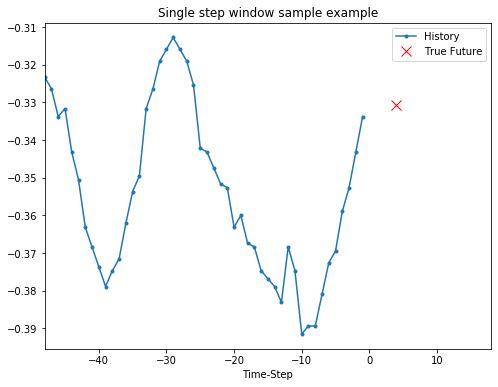

In [13]:
history = 48
future = 4

x_train, y_train = data_windows(ndata, 0, train_split, history, future, single_step=True)
x_validate, y_validate = data_windows(ndata, train_split, None, history, future, single_step=True)

print ('Sample window {}'.format(x_train[0]))
print ('Target level value {}'.format(y_train[0]))

def show_single_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = list(range(-plot_data[0].shape[0], 0))
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

show_single_plot([x_train[0], y_train[0]], future, 'Single step window sample example')

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far. In this experiment, we will use a specialized RNN layer called Long Short Term Memory (LSTM):

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 4s 22ms/step - loss: 0.2449 - val_loss: 0.0136
Epoch 2/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0688 - val_loss: 0.0116
Epoch 3/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0360 - val_loss: 0.0108
Epoch 4/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0279 - val_loss: 0.0126
Epoch 5/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0237 - val_loss: 0.0107
Epoch 6/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0213 - val_loss: 0.0104
Epoch 7/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0202 - val_loss: 0.0095
Epoch 8/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0192 - val_loss: 0.0123
Epoch 9/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0185 - val_loss: 0.0115
Epoch 10/10
200/200 [==============================] - 2

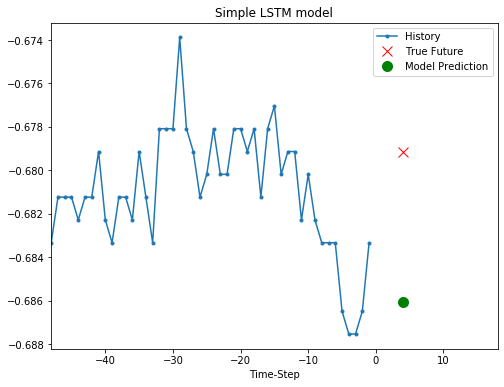

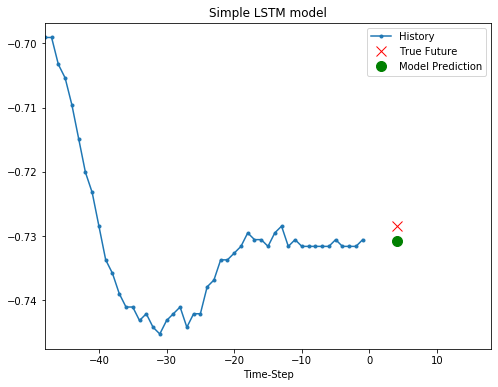

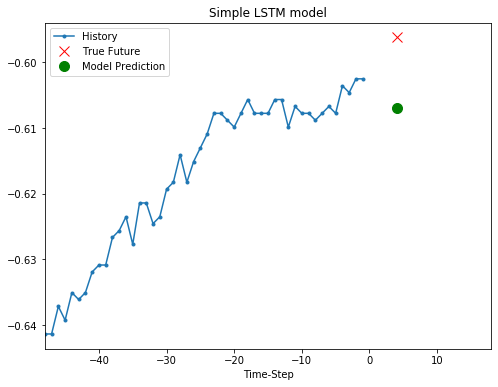

In [14]:
batch_size = 256
buffer_size = 10000

train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train = train.cache().shuffle(buffer_size).batch(batch_size).repeat()

validate = tf.data.Dataset.from_tensor_slices((x_validate, y_validate))
validate = validate.batch(batch_size).repeat()

simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

simple_lstm_model.fit(train, epochs=10,
                      steps_per_epoch=200,
                      validation_data=validate, validation_steps=50)

for x, y in validate.take(3):
  plot = show_single_plot([x[0].numpy(), y[0].numpy(),
                          simple_lstm_model.predict(x)[0]], future, 'Simple LSTM model')
  plot.show()

We will then work with the multi-step setup, ie given a past history, the model needs to learn to predict a range of future values. Data setup and model training is pretty similar except since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers.

Sample window [[-0.32325655]
 [-0.32640591]
 [-0.33375441]
 [-0.33165484]
 [-0.34320248]
 [-0.35055098]
 [-0.36314841]
 [-0.36839734]
 [-0.37364627]
 [-0.3788952 ]
 [-0.37469605]
 [-0.3715467 ]
 [-0.36209863]
 [-0.35370034]
 [-0.3495012 ]
 [-0.33165484]
 [-0.32640591]
 [-0.31905741]
 [-0.31590806]
 [-0.3127587 ]
 [-0.31590806]
 [-0.31905741]
 [-0.32535613]
 [-0.3421527 ]
 [-0.34320248]
 [-0.34740163]
 [-0.35160077]
 [-0.35265055]
 [-0.36314841]
 [-0.35999905]
 [-0.36734755]
 [-0.36839734]
 [-0.37469605]
 [-0.37679563]
 [-0.3788952 ]
 [-0.38309434]
 [-0.36839734]
 [-0.37469605]
 [-0.39149262]
 [-0.38939305]
 [-0.38939305]
 [-0.38099477]
 [-0.37259648]
 [-0.36944713]
 [-0.35894927]
 [-0.35265055]
 [-0.34320248]
 [-0.33375441]]
Target level values [-0.33165484 -0.32640591 -0.32640591 -0.3274557  -0.33060505 -0.32850548
 -0.33165484 -0.33165484]


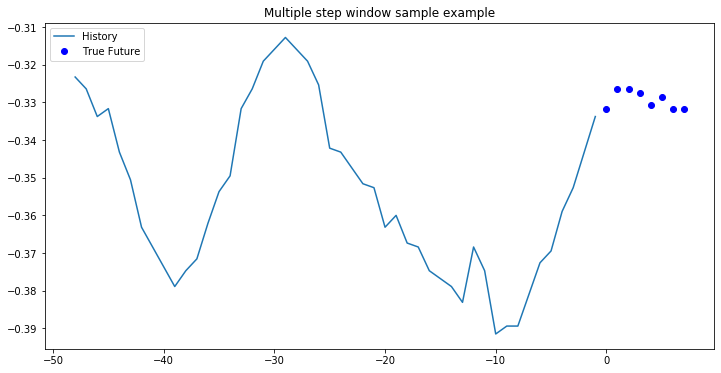

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 19s 97ms/step - loss: 0.2304 - val_loss: 0.0208
Epoch 2/10
200/200 [==============================] - 15s 74ms/step - loss: 0.0578 - val_loss: 0.0402
Epoch 3/10
200/200 [==============================] - 15s 74ms/step - loss: 0.0429 - val_loss: 0.0403
Epoch 4/10
200/200 [==============================] - 15s 74ms/step - loss: 0.0373 - val_loss: 0.0285
Epoch 5/10
200/200 [==============================] - 15s 74ms/step - loss: 0.0340 - val_loss: 0.0218
Epoch 6/10
200/200 [==============================] - 15s 75ms/step - loss: 0.0321 - val_loss: 0.0250
Epoch 7/10
200/200 [==============================] - 15s 74ms/step - loss: 0.0304 - val_loss: 0.0264
Epoch 8/10
200/200 [==============================] - 15s 73ms/step - loss: 0.0291 - val_loss: 0.0175
Epoch 9/10
200/200 [==============================] - 15s 74ms/step - loss: 0.0278 - val_loss: 0.0175
Epoch 10/10
200/200 [==================

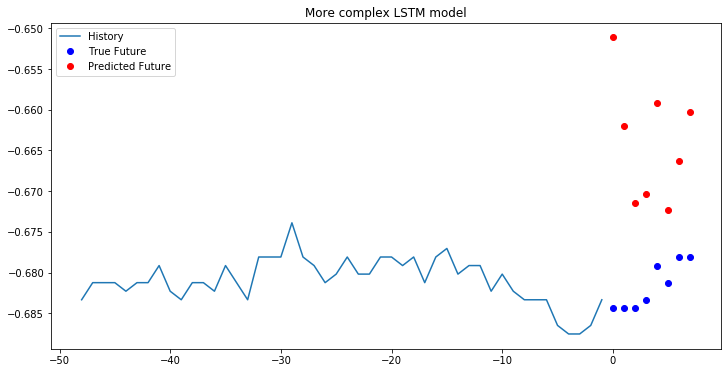

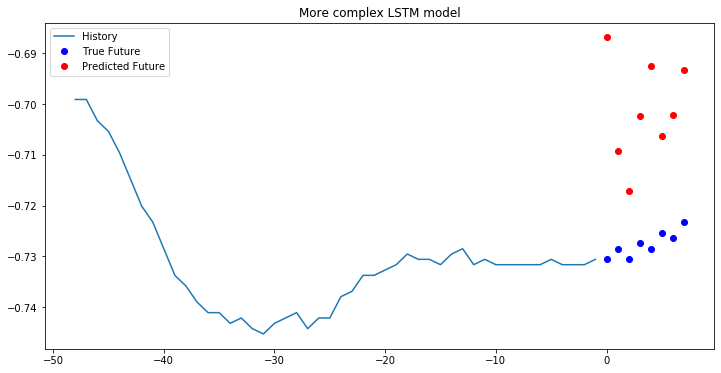

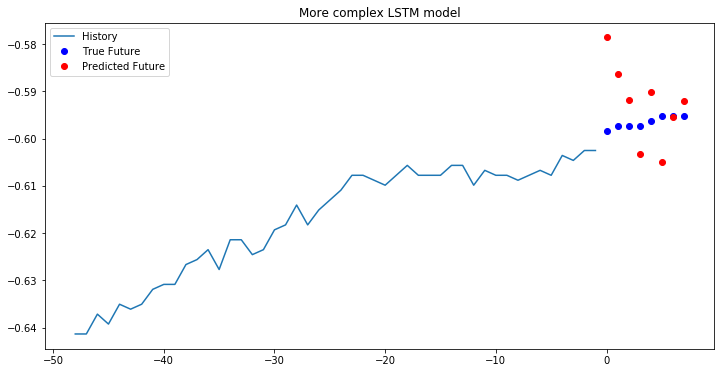

In [15]:
history = 48
future = 8

x_train, y_train = data_windows(ndata, 0, train_split, history, future, single_step=False)
x_validate, y_validate = data_windows(ndata, train_split, None, history, future, single_step=False)

print ('Sample window {}'.format(x_train[0]))
print ('Target level values {}'.format(y_train[0]))

def show_multiple_plot(history, true_future, prediction, title):
  plt.figure(figsize=(12, 6))
  num_in = list(range(-len(history), 0))
  num_out = len(true_future)

  plt.title(title)
  plt.plot(num_in, np.array(history), label='History')
  plt.plot(np.arange(num_out), np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out), np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()
    
show_multiple_plot(x_train[0], y_train[0], np.empty([0]), 'Multiple step window sample example')

train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train = train.cache().shuffle(buffer_size).batch(batch_size).repeat()

validate = tf.data.Dataset.from_tensor_slices((x_validate, y_validate))
validate = validate.batch(batch_size).repeat()

multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(future))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

multi_step_history = multi_step_model.fit(train, epochs=10,
                                          steps_per_epoch=200,
                                          validation_data=validate,
                                          validation_steps=50)

for x, y in validate.take(3):
  show_multiple_plot(x[0], y[0], multi_step_model.predict(x)[0], 'More complex LSTM model')